<a href="https://colab.research.google.com/github/quartermaine/LLMs_Open/blob/main/Neo4j_plot_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# -- START NOTEBOOK

**Implementing a Query Chain for Interacting with a Neo4j Database**

This notebook demonstrates a query chain designed to interact with a demo graph database hosted in Neo4j AuroraDB (see [here](#cell-id)). The goal is to retrieve natural language responses based on user queries and, when applicable, to construct and display a graph representing the query results.

Key Features:

- Natural Language Queries: Allows users to input queries to retrieve information from the Neo4j database.
- Graph Visualization: Capable of generating and displaying graphs based on certain query responses that involve nodes and relationships.

Technologies Used:

- Neo4j Database: Utilizes a demo environment to showcase query capabilities and graph visualization.
- Python and Cypher Queries: Integrates Python code with Cypher queries to execute database operations and retrieve structured data.
- Azure OpenAI API: Enhances query capabilities and responses using advanced natural language understanding provided by Azure OpenAI.

Environment Setup:
Before running the notebook, define the following environment variables in the secrets section of your Google Colab notebook:

- AZURE_OPENAI_API_KEY: Your Azure OpenAI API key.
- AZURE_OPENAI_ENDPOINT: Your Azure OpenAI deployment endpoint URL.
- Deployment Name: The name of your Azure OpenAI deployment.
- OPENAI_API_TYPE: The type of API (for this notebook, it is "azure").
- OPENAI_API_VERSION: The Azure OpenAI version.


By setting up these environment variables, you ensure seamless integration and functionality of the query chain, which combines Neo4j database querying with LLMs capabilities from Azure OpenAI





## Neo4j Cypher Chain

In [ ]:
#@title Install Libraries

%%capture
%pip install yfiles_jupyter_graphs --quiet
%pip install neo4j --quiet
%pip install langchain
%pip install yfiles_jupyter_graphs_for_neo4j
%pip install 'crewai[tools]'


from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget


In [ ]:
#@title Import google custom manager

try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass


In [ ]:
#@title Create Neo4j connection class

class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

    def get_schema(self):
        node_labels_query = "CALL db.labels()"
        relationship_types_query = "CALL db.relationshipTypes()"
        property_keys_query = "CALL db.propertyKeys()"

        node_labels = [record["label"] for record in self.query(node_labels_query)]
        relationship_types = [record["relationshipType"] for record in self.query(relationship_types_query)]
        property_keys = [record["propertyKey"] for record in self.query(property_keys_query)]

        self.structured_schema = {
            "node_labels": node_labels,
            "relationship_types": relationship_types,
            "property_keys": property_keys
        }

        # print("Schema retrieved successfully: ", self.structured_schema)  # Debug statement

        return self.structured_schema  # Return the schema


In [ ]:
#@title Create Cypher chain
# code reference https://neo4j.com/developer-blog/rag-cypher-vector-templates-langchain-agent/

from langchain.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
from langchain.chat_models import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.tools import BaseTool
from google.colab import userdata
from typing import Type
import json
import os
import re

# Set AZ OpenAI credentials
os.environ["OPENAI_API_VERSION"] = userdata.get('OPENAI_API_VERSION') #
os.environ["OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY') #
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
os.environ["DEPLOYMENT_NAME"] = userdata.get('DEPLOYMENT_NAME') #
os.environ["MODEL_NAME"] =  userdata.get('MODEL_NAME') #

# Set Neo4j credentials
os.environ["NEO4J_URI"] = "neo4j+s://607c7401.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "de1ncgZ_oR1GqeGZW5Q7IVeIkUF3sF3dVnmsn0c8-h0"


class Question(BaseModel):
    question: str

class CypherTool(BaseTool):
    name = "graph_tool"
    description = "Useful Tool for retrieving structural, interconnected and relational knowledge"
    args_schema: Type[Question] = Question


    def get_query(self, query):
        # print(f'THE INITIAL QUERY IS: {query}\n')
        cypher_query = None
        pattern = r'```cypher\s*(.*?)\s*```'
        match = re.search(pattern, query, re.DOTALL)
        if match:
            cypher_query = match.group(1).strip()
            # print(f"Matched query is: {cypher_query}")
            return cypher_query
        else:
            # print(f"Not matched query is: {query}")
            return query.strip()

    def _run(self, question):
        # Connection to Neo4j
        graph = Neo4jConnection(
            uri=os.getenv("NEO4J_URI"),
            user=os.getenv("NEO4J_USERNAME"),
            pwd=os.getenv("NEO4J_PASSWORD")
        )

        # Retrieve the schema
        schema = graph.get_schema()
        if not schema:
            raise ValueError("Failed to retrieve schema.")

        # print("Structured schema: ", schema)  # Debug statement

        # Cypher validation tool for relationship directions
        corrector_schema = [
            Schema("", rel_type, "")
            for rel_type in schema.get("relationship_types", [])
        ]

        cypher_validation = CypherQueryCorrector(corrector_schema)

        # LLMs
        llm_az = AzureChatOpenAI(
            model=os.environ.get("MODEL_NAME"),
            deployment_name=os.environ.get("DEPLOYMENT_NAME"),
        )
        cypher_llm = llm_az
        qa_llm = llm_az

        # Generate Cypher statement based on natural language input
        cypher_template = """This is important for my career.
        Based on the Neo4j graph schema below, write a Cypher query that would answer the user's question:
        {schema}

        Question: {question}
        Cypher query:"""

        cypher_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "Given an input question, convert it to a Cypher query. No pre-amble.",
                ),
                ("human", cypher_template),
            ]
        )

        cypher_response = (
            RunnablePassthrough.assign(schema=lambda _: schema)
            | cypher_prompt
            | cypher_llm.bind(stop=["\nCypherResult:"])
            | StrOutputParser()
        )

        # Generate natural language response based on database results
        response_template = """Based on the the question, Cypher query, and Cypher response, write a natural language response:
        Question: {question}
        Cypher query: {query}
        Cypher Response: {response}"""

        response_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "Given an input question and Cypher response, convert it to a "
                    "natural language answer. No pre-amble.",
                ),
                ("human", response_template),
            ]
        )

        chain = (
            RunnablePassthrough.assign(query=cypher_response)
            | RunnablePassthrough.assign(
                response=lambda x: graph.query(self.get_query(x["query"])), # cypher validator has been removed
                                                                            # as not returning correct output
            )
            | RunnablePassthrough.assign(
                output=response_prompt | qa_llm | StrOutputParser(),
            )
        ).with_types(input_type=Question)

        return (
            chain.invoke({"question": question})
        )


In [ ]:
#@title Run query chain

# Initialize and use the tool
cypher_tool = CypherTool()
# result = cypher_tool.run('Which is the director and the actors in the movie "The Matrix"') # cypher code no graph output
result = cypher_tool.run('What are the nodes, relationships, labels and directions in the movie "The Matrix"') # cypher code graph output
# result = cypher_tool.run('What are the movies, in which the actor "Keanu Reeves" has played?') # cypher code no graph output


In [ ]:
#@title Print the chain output

def convert_to_serializable(record):
    def serialize(value):
        if isinstance(value, (set, frozenset)):
            return list(value)
        elif isinstance(value, dict):
            return {k: serialize(v) for k, v in value.items()}
        elif isinstance(value, list):
            return [serialize(item) for item in value]
        elif hasattr(value, 'keys') and hasattr(value, '__getitem__'):
            return dict(value)
        else:
            return value

    serializable_record = {}

    for key, value in record.items():
        serializable_record[key] = serialize(value)

    return serializable_record

# Convert Neo4j-specific objects to serializable dictionaries
serializable_response = [convert_to_serializable(record) for record in result['response']]

# Replace the original response with the serializable version
result['response'] = serializable_response

# Pretty print the result
pretty_result = json.dumps(result, indent=4)
print(pretty_result)


{
    "question": "What are the nodes, relationships, labels and directions in the movie \"The Matrix\"",
    "query": "```cypher\nMATCH (m:movies {Series_Title: \"The Matrix\"})-[r]-(n)\nRETURN m, r, n, labels(m), labels(n), type(r), startNode(r), endNode(r)\n```",
    "response": [
        {
            "m": {
                "Series_Title": "The Matrix"
            },
            "r": {},
            "n": {
                "Released_Year": 1999
            },
            "labels(m)": [
                "movies"
            ],
            "labels(n)": [
                "year"
            ],
            "type(r)": "RELEASED",
            "startNode(r)": {
                "Series_Title": "The Matrix"
            },
            "endNode(r)": {
                "Released_Year": 1999
            }
        },
        {
            "m": {
                "Series_Title": "The Matrix"
            },
            "r": {},
            "n": {
                "Director": "Lana Wachowski"
           

In [ ]:
#@title Print the generated cypher code

print(f" The generated cypher code is: \n\n {result['query']}")


 The generated cypher code is: 

 ```cypher
MATCH (m:movies {Series_Title: "The Matrix"})-[r]-(n)
RETURN m, r, n, labels(m), labels(n), type(r), startNode(r), endNode(r)
```


In [ ]:
#@title Get the clean cypher code

import re

# print(result)

# Define a regular expression to match the Cypher code
pattern = re.compile(r'```cypher\n(.*?)\n```', re.DOTALL)

# Search for the pattern in the text
match = pattern.match(result['query'])

# Extract the Cypher code if found
if match:
    cypher_code = match.group(1).strip()
    print("Extracted Cypher Code:\n\n", cypher_code)
else:
  cypher_code = None
  print("No Cypher code found.")


Extracted Cypher Code:

 MATCH (m:movies {Series_Title: "The Matrix"})-[r]-(n)
RETURN m, r, n, labels(m), labels(n), type(r), startNode(r), endNode(r)


In [ ]:
#@title Create neo4j plot #1

# create a neo4j session to run queries
driver = GraphDatabase.driver(uri = os.getenv('NEO4J_URI'),
                              auth = (
                                  os.getenv('NEO4J_USERNAME'),
                                  os.getenv('NEO4J_PASSWORD')
                                  ),
                              database = 'neo4j'
                              )
session = driver.session()

w2 = GraphWidget(graph = session.run(cypher_code).graph())

def custom_node_label_mapping(index, node):
    """let the label be the name or the title"""
    properties = node.get('properties', {})
    return properties.get('title', properties.get('name', 'no label'));

def custom_relationship_label_mapping(index, node):
    """let the label be the role"""
    properties = node.get('properties', {})
    return properties.get('roles', ['no role'])[0];

w2.node_label_mapping = custom_node_label_mapping
w2.edge_label_mapping = custom_relationship_label_mapping

# w2.hierarchic_layout()
display(w2)


GraphWidget(layout=Layout(height='500px', width='100%'))

In [ ]:
#@title Create neo4j plot #2

from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
from neo4j import GraphDatabase

g = Neo4jGraphWidget(driver)

g.show_cypher(cypher_code)


GraphWidget(layout=Layout(height='500px', width='100%'))

## Agent (To be implemeted)

In [ ]:
#@title Import Libraries

# import os
# from crewai import Agent, Task, Crew, Process
# from langchain.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
# from textwrap import dedent

# # Set up API keys

In [ ]:
#@title Create agent tasks

# class CypherTasks:
#     def code_creator(self, agent, schema):
#       return Task(description=dedent(f"""
#          Based on the Neo4j graph schema below, write a Cypher query that would answer the user's question:
#         {schema}
#         Retrurn the Cypher query with no additional comments.
#         Question: question
#         Cypher query:
#         """),
#         expected_output=dedent(f"""
#             Cypher Code that answers the question
#         """),
#         agent=agent
#         )

#     def code_validator(self, agent,):
#       return Task(description=dedent(f"""
#             Your task is to validate the following Cypher code:
#             from {self.code_creator}
#         """),
#         expected_output=dedent(f"""
#             Validated Cypher Code
#         """),
#         agent=agent
#         )

In [ ]:
#@title Create agent goals

# from google.colab import userdata
# from langchain_openai import AzureChatOpenAI

# os.environ["OPENAI_API_VERSION"] = userdata.get('OPENAI_API_VERSION') #
# os.environ["OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY') #
# os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
# os.environ["DEPLOYMENT_NAME"] = userdata.get('DEPLOYMENT_NAME') #
# os.environ["MODEL_NAME"] =  userdata.get('MODEL_NAME') #
# os.environ['GROQ_API_KEY'] =  userdata.get('GROQ_API_KEY') #


# class CyperAgents:
#     def __init__(self):
#         print("Initializing DataAnalysisAgents...")

#         self.llm_az = AzureChatOpenAI(
#             model=os.environ.get("MODEL_NAME"),
#             deployment_name=os.environ.get("DEPLOYMENT_NAME"),
#         )

#         # Print statements to verify LLM initialization
#         # print(f"Azure LLM: {self.llm_az}")
#         # print(f"Phi3 LLM: {self.llm_phi3}")
#         # print(f"Llama3 LLM: {self.llm_llama3}")
#         # print(f"OpenHermes LLM: {self.llm_openhermes}")
#         # print(f"ChatGroq LLM: {self.llm_crewai}")

#     def get_model(self,):

#         return self.llm_az


#     def code_agent(self, ):

#         print('---> init code generation agent')
#         return Agent(
#             role="Cypher Code Creation Agent",
#             goal=dedent("""
#                 Analyze the schema and provide a code in Cypher in order to
#                 create a graph
#             """),
#             backstory=dedent("""
#                 As a professional in cypher code creation generate code to
#                 run on a neo4j db.
#             """),
#             llm=self.llm_az,
#             verbose=True
#         )

#     def validation_agent(self, ):

#         print('---> init code validation agent')
#         return Agent(
#             role="Cypher code validator",
#             goal=dedent(f"""
#                 Validate the code from the result of {self.code_agent}

#             """),
#             backstory=dedent("""
#                 Validate if the generated code is correct.
#             """),
#             llm=self.llm_az,
#             # tools=[CypherQueryCorrector],
#             verbose=True
#         )


In [ ]:
#@title Create Crew

# tasks = CypherTasks()
# agents = CyperAgents()

# print('*************************************')
# print("* Welcome to the Data analysis Crew *")
# print('*************************************')

# # Create Agents
# print('--> Init Agents')
# code_gen_agent = agents.code_agent()
# code_val_agent = agents.validation_agent()
# # plot_agent = agents.plot_creator_agent()

# # Create Tasks
# print('--> Init Tasks')
# code_gen_task = tasks.code_creator(code_gen_agent,schema )
# code_val_task = tasks.code_validator(code_val_agent)
# # plot_creation = tasks.plot_creation(plot_agent, data)
# print('--> Init model')
# llm_choice = agents.get_model()

# # Create Crew plot
# print('--> Create Crew')
# crew = Crew(
#     agents=[
#         code_gen_agent,
#         code_val_agent,
#         # plot_agent
#         ],
#     tasks=[
#         code_gen_task,
#         code_val_task,
#         # plot_creation
#         ],
#     manager_llm=llm_choice,
#     process=Process.hierarchical,
#     verbose=True
#     )

# result = crew.kickoff()

# # Print results
# print("\n\n########################")
# print("## Here is the result ##")
# print("########################\n")
# print("\n\nThe resulting code is:")
# print(result)


<a name="cell-id"></a>

## Neo4j AuraDB

Neo4j AuraDB is a cloud service that enables you to create and manage graph databases. Follow these steps to set the database:

- Create a Free Account on Neo4j AuraDB:

   - Visit the Neo4j AuraDB website and sign up for a free account.
- Create a Free Instance:

    - After logging in, create a free instance to host your graph database. Make sure to securely store the password and connection string, as you will need these details later.
    - Insert the connection string and password into the 'Create Cypher Chain' cell in the notebook.
- Download the Data File:

    - Download the [csv file](https://github.com/ibiscp/LLM-IMDB/blob/main/data/imdb_top_1000.csv)  containing the data used to create the database.
-Import the CSV File and Create Nodes and Relationships:

    - Using the connection details from your Neo4j AuraDB instance, import the CSV file and create the specified nodes and relationships to build the graph database.

       - Nodes:

          - movie: Properties - Series_Title
          - director: Properties - Director
          - genre: Properties - Genre
          - year: Properties - Released_year
          - actor_1: Properties - Star1
          - actor_2: Properties - Star2
          - actor_3: Properties - Star3
          - actor_4: Properties - Star4

       - Relationships:
           - RELEASED: Between director:Director and movies:Series_Title
           - ACTED_IN: Between actor_(1-4): Star(1-4) and movies:Series_Title
           - BELONGS_TO: Between movie:Series_Title and genre:Genre

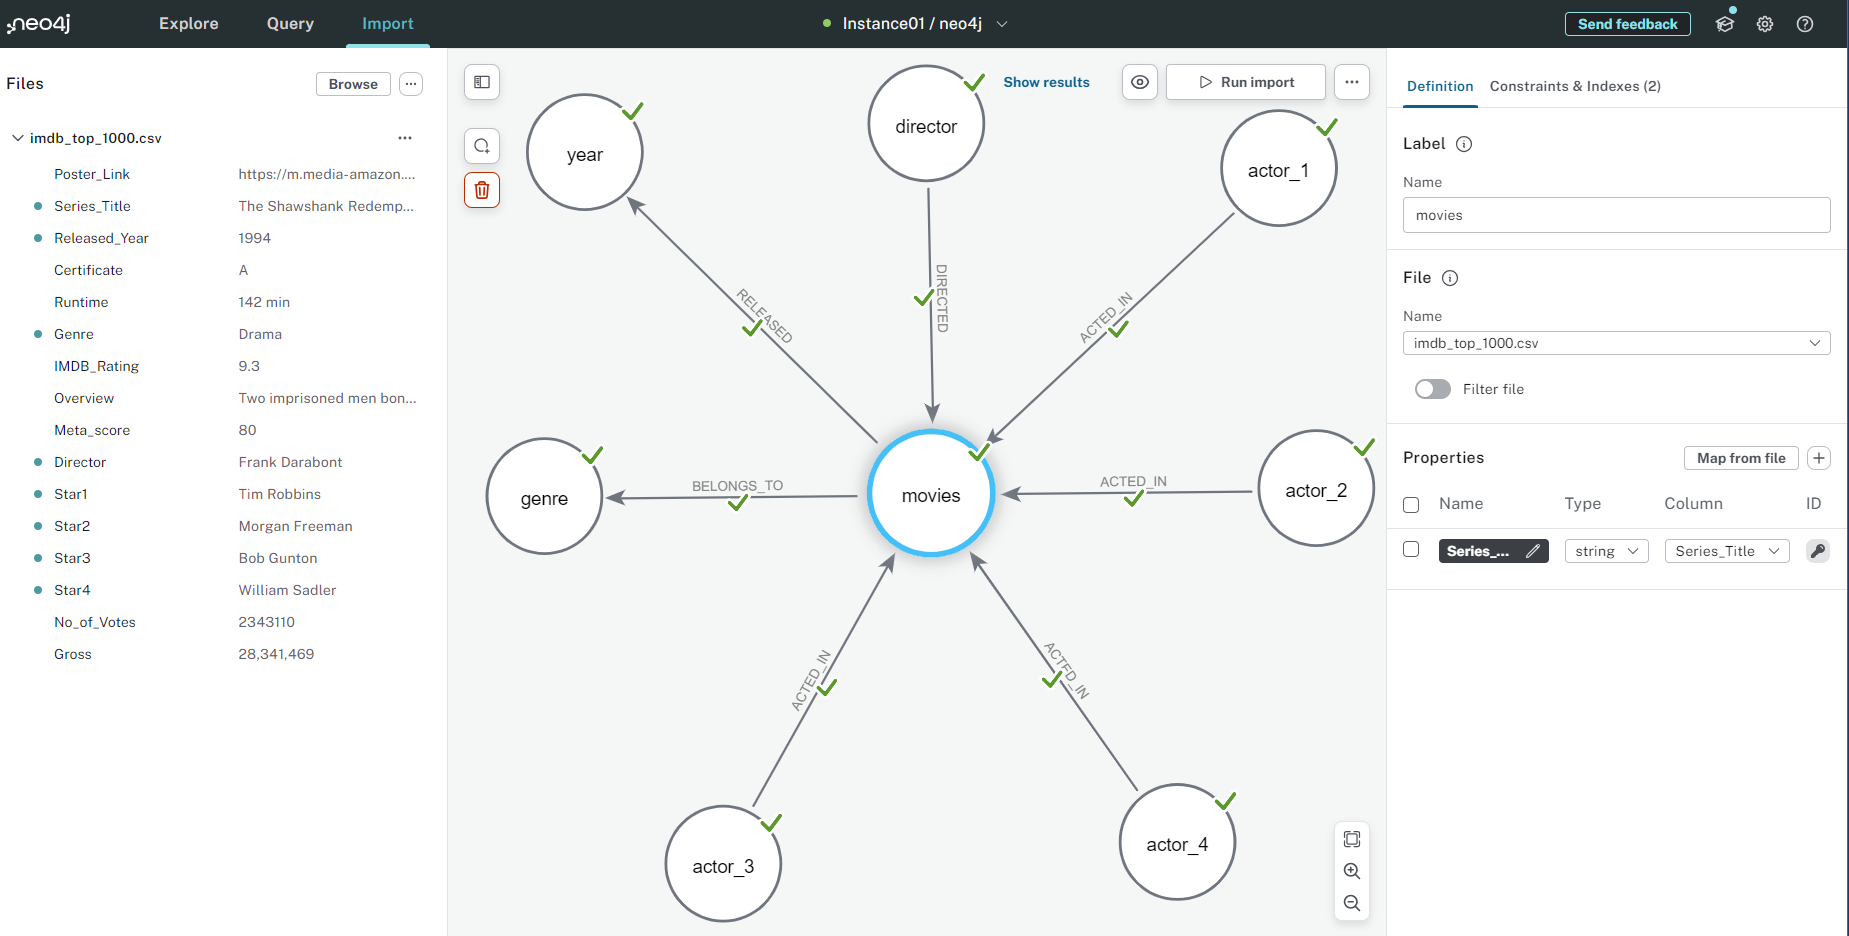



## Resources


- https://python.langchain.com/v0.2/docs/tutorials/graph/

- https://python.langchain.com/v0.2/docs/integrations/graphs/neo4j_cypher/

- https://python.langchain.com/v0.2/docs/integrations/providers/neo4j/

- https://github.com/yWorks/yfiles-jupyter-graphs?tab=readme-ov-file

- https://colab.research.google.com/github/yWorks/yfiles-jupyter-graphs/blob/main/examples/16_neo4j_import.ipynb#scrollTo=ac965084-deff-4721-9afe-c7319f1f5579

- https://colab.research.google.com/drive/1J9__HotNoINHpucoipLH-4qWc48GALAk?usp=sharing#scrollTo=guXxJj1nBZMe

- https://docs.crewai.com/core-concepts/Tools/

- https://demo.neo4jlabs.com:7473/browser/ (neo4j environment to see the demo movies db)

- https://neo4j.com/labs/genai-ecosystem/langchain/#_cypherqachain

- https://neo4j.com/developer-blog/rag-cypher-vector-templates-langchain-agent/


# -- END NOTEBOOK